    Copyright (C) 2015 Jingkun Gao (jingkun@cmu.edu)
    
    This file is part of PLAID code repo.
    
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>

In this IPython Notebook, I will show how to load data and extract features from PLAID. Meanwhile, I will test the performance of appliance identification using PLAID.

<span style="color:red">Please make sure Python3 and other necessary packages (using **pip3 -r requirements.txt**) are installed,</span>

In [1]:
# !pip install -r requiements.txt

In [2]:
%matplotlib inline

import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
plt.style.use('ggplot')

from pylab import rcParams
rcParams['figure.figsize'] = (10, 6)

import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 17}
matplotlib.rc('font', **font)

import warnings
warnings.filterwarnings("ignore")

In [3]:
# functions to read data and meta data
def read_data_given_id(path,ids,progress=True,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    start = datetime.now()
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress and np.mod(i,np.ceil(n/10))==0:
                print('%d/%d (%2.0f%s) have been read...\t time consumed: %ds'\
                      %(i,n,i/n*100,'%',(datetime.now()-start).seconds))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',delimiter=',',\
                                         names='current,voltage',dtype=(float,float))
            else:
                p=subprocess.Popen(['tail','-'+str(int(last_offset)),path+str(ist_id)+'.csv'],\
                                   stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',names='current,voltage',dtype=(float,float))
        print('%d/%d (%2.0f%s) have been read(Done!) \t time consumed: %ds'\
            %(n,n,100,'%',(datetime.now()-start).seconds)) 
        return data


def clean_meta(ist):
    '''remove None elements in Meta Data ''' 
    clean_ist = ist.copy()
    for k,v in ist.items():
        if len(v) == 0:
            del clean_ist[k]
    return clean_ist
                
def parse_meta(meta):
    '''parse meta data for easy access'''
    M = {}
    for m in meta:
        for app in m:
            M[int(app['id'])] = clean_meta(app['meta'])
    return M


In [4]:
# specify path to read data and meta
# Please make sure you downloaded latest dataset from plaidplug.com.
Data_path = 'data/'
csv_path = Data_path + 'CSV/';

import json

# read meta
with open(Data_path + 'meta1.json') as data_file:    
    meta1 = json.load(data_file)

    
Meta = parse_meta([meta1])
meta1 = parse_meta([meta1])

In [5]:
# read data
# applinace types of all instances
Types = [x['type'] for x in Meta.values()]
# unique appliance types
Unq_type = list(set(Types)) 
Unq_type.sort()
IDs_for_read_data = list(Meta.keys())
# households of appliances
Locs = [x['header']['collection_time']+'_'+x['location'] for x in Meta.values()]
# unique households
Unq_loc = list(set(Locs))
Unq_loc.sort()
Origianl_Unq_type = Unq_type

In [6]:
print('Number of households: %d\nNumber of total measurements:%d'%(len(Unq_loc),len(Locs)))

Number of households: 55
Number of total measurements:1074


In [7]:
# read data
# estimated time cost:  ~ 1 mins
npts = 10000
Data = read_data_given_id(csv_path,IDs_for_read_data,progress=True, last_offset=npts)

108/1074 (10%) have been read...	 time consumed: 8s
216/1074 (20%) have been read...	 time consumed: 16s
324/1074 (30%) have been read...	 time consumed: 23s
432/1074 (40%) have been read...	 time consumed: 30s
540/1074 (50%) have been read...	 time consumed: 38s
648/1074 (60%) have been read...	 time consumed: 45s
756/1074 (70%) have been read...	 time consumed: 52s
864/1074 (80%) have been read...	 time consumed: 60s
972/1074 (91%) have been read...	 time consumed: 67s
1074/1074 (100%) have been read(Done!) 	 time consumed: 74s


In [8]:
print('Total number of instances:%d'%len(Data))

Total number of instances:1074


We start by extracting one representative period of steady state for each instance.

In [9]:
fs = 30000
f0 = 60
NS = fs//f0 # number of samples per period
NP = npts//NS # number of periods for npts

# calculate the representative one period of steady state 
# (mean of the aggregated signals over one cycle)
n = len(Data)
rep_I = np.empty([n,NS])
rep_V = np.empty([n,NS])
for i in range(n):
    tempI = np.sum(np.reshape(Data[i+1]['current'],[NP,NS]),0)/NP
    tempV = np.sum(np.reshape(Data[i+1]['voltage'],[NP,NS]),0)/NP
    # align current to make all samples start from 0 and goes up
    ix = np.argsort(np.abs(tempI))
    j = 0
    while True:
        if ix[j]<499 and tempI[ix[j]+1]>tempI[ix[j]]:
            real_ix = ix[j]
            break
        else:
            j += 1
    rep_I[i,] = np.hstack([tempI[real_ix:],tempI[:real_ix]])
    rep_V[i,] = np.hstack([tempV[real_ix:],tempV[:real_ix]])

Extract labels for appliance type and locations(used for train/test split).

In [10]:
type_Ids = {}
loc_Ids = {}
n = len(Data)
type_label = np.zeros(n,dtype='int')
loc_label = np.zeros(n,dtype='int')
for (ii,t) in enumerate(Unq_type):
    type_Ids[t] = [i-1 for i,j in enumerate(Types,start=1) if j == t]
    type_label[type_Ids[t]] = ii+1
for (ii,t) in enumerate(Unq_loc):
    loc_Ids[t] = [i-1 for i,j in enumerate(Locs,start=1) if j == t]
    loc_label[loc_Ids[t]] = ii+1
print('number of different types: %d'% len(Unq_type))
print('number of different households: %d'% len(Unq_loc))

number of different types: 11
number of different households: 55


We then look at the distributions of appliance types and locations.

['Air Conditioner', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Vacuum', 'Washing Machine']
Similified verstion:
['AC', 'CFL', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'Bulb', 'Laptop', 'Microwave', 'Vacuum', 'Washer']


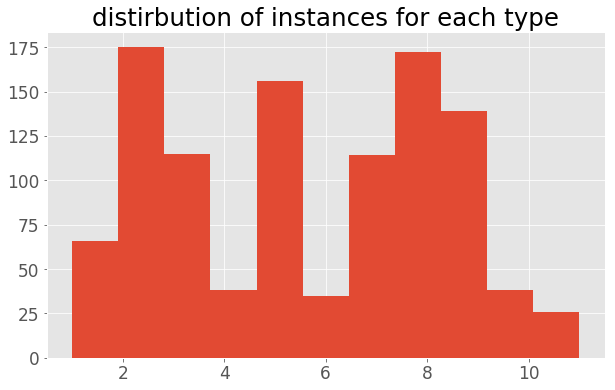

In [11]:
plt.hist(type_label,len(Unq_type))
plt.title('distirbution of instances for each type')
print(Origianl_Unq_type)
print('Similified verstion:')
Unq_type[0]='AC';
Unq_type[1]='CFL';
Unq_type[6]='Bulb';
Unq_type[10]='Washer';
print(Unq_type)
plt.savefig('type_dist.eps', format='eps')

We can see that we have an unbalanced dataset, more instances for CFL, Hairdryer, Laptop and less for Fridge, Heater, Vacuum and Washing Machine.

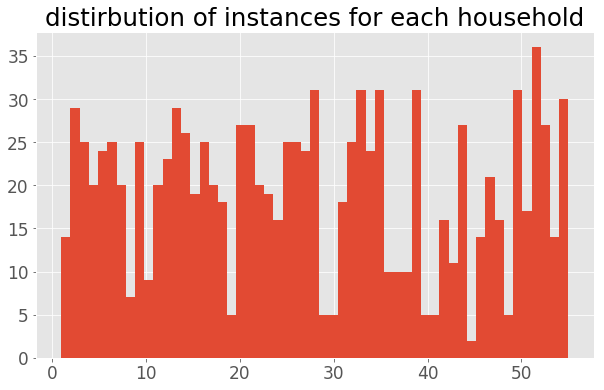

In [12]:
plt.hist(loc_label,len(Unq_loc))
plt.title('distirbution of instances for each household')
plt.savefig('house_dist.eps', format='eps')

Next, we have rep_I, rep_V, type_label, loc_label. We will start from here to extract features and evalute classification performance. To begin, we first write a function for classifiers.

# Classifiers 

In [13]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

def myclassifiers(X_train,y_train,X_test,y_test,verbose=False):
    
    knn = KNeighborsClassifier(n_neighbors=1)
    gnb = GaussianNB()
    logistic = LogisticRegression(C=1e5)
    svc = svm.SVC(kernel='rbf',gamma=.7,C=1.0)
    lda = LDA(solver='lsqr', shrinkage='auto')
    qda = QDA()
    dTree = tree.DecisionTreeClassifier(max_depth=10)
    rForest = RandomForestClassifier(max_depth=10,n_estimators=20)
    adaBoost = AdaBoostClassifier()
    
    names = ["Nearest Neighbors(k=1)", "Naive Bayes","Logistic","RBF SVM", "LDA", "QDA",
             "Decision Tree","Random Forest", "AdaBoost"]
    classifiers = [knn, gnb, logistic, svc, lda, qda, dTree, rForest, adaBoost]
    y_predict = []
    acc = []
#     print('Running',end="")
    for (i,clf) in enumerate(classifiers):
        if verbose:
            print(' %s... '% names[i],end="")
        clf.fit(X_train,y_train)
        y_predict.append(clf.predict(X_test))
        acc.append(clf.score(X_test,y_test))
    return (acc,y_predict,names)

In [14]:
# test classifiers

X_train, X_test, y_train, y_test = train_test_split(rep_I[:,:10], type_label, test_size=0.1, random_state=0)
(acc,y_p,names) = myclassifiers(X_train,y_train,X_test,y_test)

In [15]:
acc

[0.62037037037037035,
 0.46296296296296297,
 0.40740740740740738,
 0.47222222222222221,
 0.41666666666666669,
 0.47222222222222221,
 0.55555555555555558,
 0.60185185185185186,
 0.21296296296296297]

# Features

## 1. Raw Current 
**RawCF**

Fridge


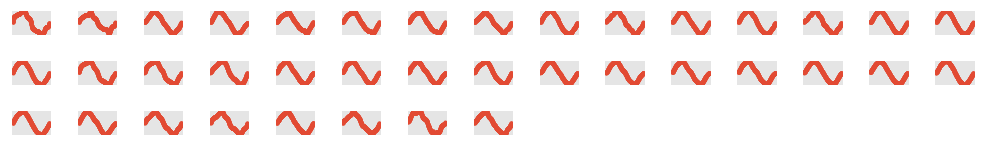

In [16]:
RawCF = rep_I
# visualization of current features from certain type in RawCF
type_id = 4
n = sum(type_label==type_id)
fig = plt.figure(figsize=(14,np.ceil(n/15)))
count = 1
for i in np.where(type_label==type_id)[0]:
    plt.subplot(np.ceil(n/10),15,count)
    plt.plot(RawCF[i,],'.')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     plt.title('Id: '+str(k),fontsize=10)
    count += 1
fig.tight_layout()
print(Unq_type[type_id-1])
plt.show()  

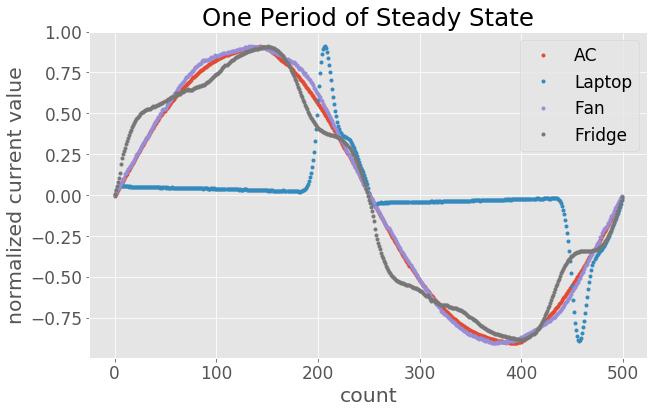

In [17]:
# plot five instances
ids = [1,8,3,4]
normalize = lambda x:x/(max(x)*1.1)
for i in ids:
    plt.plot(normalize(RawCF[np.where(type_label==i)[0][0],]),'.',label=Unq_type[i-1])
    plt.legend()
plt.xlabel('count')
plt.ylabel('normalized current value')
plt.title('One Period of Steady State')

## 2. Real/Reactive Power, PQ Plane feature
**PQ**: Calculate real and reactive power from steady states

In [18]:
f0 = 60
fs = 3e4
n = len(Data)
NN = int(fs//f0)
NS = npts//NN
PQ = np.empty([n,NS,2])

for i in range(n):
    for j in range(NS-1):
        # extract current and voltage in two cycle
        temp_I = Data[i+1]['current'][j*NN:(j+2)*NN]
        temp_V = Data[i+1]['voltage'][j*NN:(j+2)*NN]
        # extract abs part(apparent component), divided by the number of points
        apparI = np.abs(2*np.fft.fft(temp_I))/NN
        apparV = np.abs(2*np.fft.fft(temp_V))/NN
        # phase difference
        theta = np.angle(np.fft.fft(temp_V)) - np.angle(np.fft.fft(temp_I))
        # calculate real/reactive power
        tempP = 1/2*apparV*apparI*np.sin(theta)
        tempQ = 1/2*apparV*apparI*np.cos(theta)
        # sum the power of different orders
#         PQ[i,j,0] = np.sum(tempP)
#         PQ[i,j,1] = np.sum(tempQ)
        # take only the fundamental active/reactive power 
        PQ[i,j,0] = (tempP[2])
        PQ[i,j,1] = (tempQ[2])
PQ = np.delete(PQ,np.where(np.isnan(PQ))[1],1)
# choose the median value among all cycles
PQ = np.median(PQ,1)

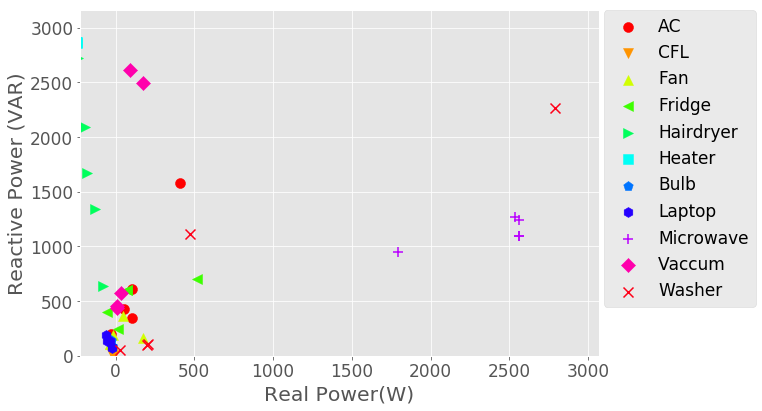

In [19]:
import matplotlib.cm as cmx
import matplotlib.colors as colors

def get_cmap(N):
    '''Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.'''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color 

cmap = get_cmap(11)
Legends=('AC','CFL','Fan','Fridge','Hairdryer','Heater','Bulb','Laptop','Microwave','Vaccum','Washer')
markers='ov^<>sph+Dx'
colors='bgrcmk'
minx,maxx,miny,maxy = (0,0,0,0)
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(1,1,1)
ax.set_position([0.1,0.1,.6,0.8])
# visualization of current features from certain type in PQ
for i in range(11):
    ix=np.where(type_label==i+1)[0]
    # ignore appliances with high real/reactive power for better visualization
    temp_PQ = np.delete(PQ[ix], np.unique(np.where(np.abs(PQ[ix]) > 3000)[0]), 0)
    ix1 = np.random.randint(temp_PQ.shape[0],size=5)
    tempx = temp_PQ[ix1,0]
    tempy = temp_PQ[ix1,1]
    plt.scatter(tempx,tempy,c=cmap(i),marker=markers[i], s=100, label=Legends[i])
    minx = min(minx,min(tempx))
    maxx = max(maxx,max(tempx))
    miny = min(miny,min(tempy))
    maxy = max(maxy,max(tempy))    
plt.axis([minx*0.9,maxx*1.1,miny*0.9,maxy*1.1])
plt.xlabel('Real Power(W)')
plt.ylabel('Reactive Power (VAR)')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# plt.tight_layout()
plt.savefig('PQ.eps', format='eps')

## 3. Harmonics
**HarmonicsF**: We will take up to 21st order of harmonics

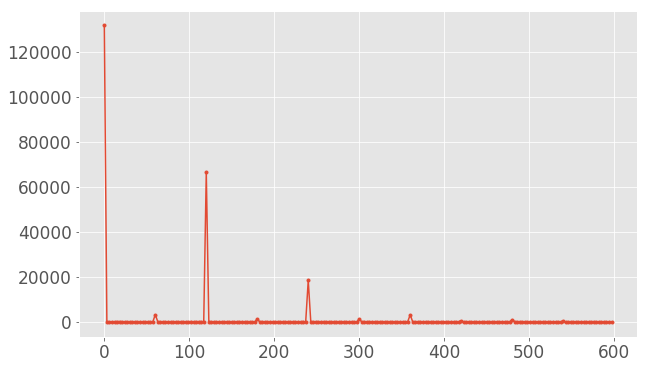

In [20]:
n = len(Data)
order = 21
p = order + 1 # number of harmonics to be extracted, include 0-th component
harmonics = np.linspace(0,order,num=p)
fs = 30000
npts = 10000
f0 = 120 # for power

HarmonicsF = np.empty([n,p])
# visualize power harmonics of one instance
ix = 100
temp_P = Data[ix]['current']*Data[ix]['voltage']
x = np.linspace(0,fs,num=npts)
y = np.abs(np.fft.fft(temp_P))
plt.plot(x[:200],y[:200],'.-')

In [21]:
harmonics

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.])

In [22]:
for i in range(n):
    temp_P = Data[i+1]['current']*Data[i+1]['voltage']
    y = np.abs(np.fft.fft(temp_P))
    h = 40*harmonics
    h = h.astype(int)
    HarmonicsF[i,] =y[h]
HarmonicsF[1,]

array([ 241954.15403439,  245235.14034795,  149656.45694216,
         60735.40515085,   38803.81561883,   24499.81562646,
         21877.30176295,   34387.33122276,   26462.95516803,
         19350.51102955,   21857.66557608,   14818.50723871,
         12411.08847785,   16376.94359118,   14223.17238561,
         13936.37074914,   13906.62194871,    9392.90600686,
          6516.84211193,    5567.63471569,    5381.62618865,
          7376.58529023])

In [23]:
HarmonicsF.shape

(1074, 22)

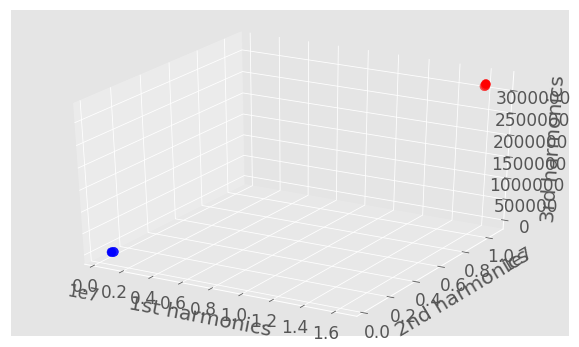

In [24]:
# visualization of harmonics features from certain type
from mpl_toolkits.mplot3d import Axes3D

ix1=np.where(type_label==9)[0][:4]
ix2=np.where(type_label==7)[0][:4]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=HarmonicsF[ix1,0], ys=HarmonicsF[ix1,1], zs=HarmonicsF[ix1,2],c='r',s=80)
ax.scatter(HarmonicsF[ix2,0], HarmonicsF[ix2,1], zs=HarmonicsF[ix2,2],c='b',s=80)
ax.set_xlabel('1st harmonics')
ax.set_ylabel('2nd harmonics')
ax.set_zlabel('3rd harmonics')

plt.show()

## 4. Down sampled current/voltage
**BinF** : This feature is to downsample the data to reduce dimension of raw current/voltage. 

In [25]:
num = 20 # number of bins

def get_BinF(X,num):
    '''X should be nd array of size N*P, the output will be N*num'''
    (N,P) = X.shape
    newP = int(np.floor(P/num)*num)
    newX = np.reshape(X[:,:newP],[N,num,newP//num])
    BinF = np.sum(newX,2)
    return BinF

BinF_I = get_BinF(rep_I,num)    
BinF_V = get_BinF(rep_V,num)    

In [26]:
BinF = np.hstack([BinF_I,BinF_V])

In [27]:
BinF.shape

(1074, 40)

In [28]:
Unq_type

['AC',
 'CFL',
 'Fan',
 'Fridge',
 'Hairdryer',
 'Heater',
 'Bulb',
 'Laptop',
 'Microwave',
 'Vacuum',
 'Washer']

In [29]:
BinF[1,:]

array([  1.71650000e+00,   1.75350000e+00,   1.56700000e+00,
         1.41700000e+00,   1.22300000e+00,   1.03950000e+00,
         1.12575000e+01,   1.89370000e+01,   1.20715000e+01,
         3.95400000e+00,  -1.60750000e+00,  -1.62750000e+00,
        -1.38850000e+00,  -1.23150000e+00,  -1.04950000e+00,
        -8.66500000e-01,  -1.11200000e+01,  -1.86765000e+01,
        -1.18595000e+01,  -3.74000000e+00,  -3.99555650e+03,
        -3.16559200e+03,  -2.13829055e+03,  -9.16609555e+02,
         4.70130156e+02,   1.70416765e+03,   2.81547730e+03,
         3.53513050e+03,   4.05019950e+03,   4.20040500e+03,
         3.96450650e+03,   3.13474400e+03,   2.10894995e+03,
         8.88079580e+02,  -5.06118388e+02,  -1.74206265e+03,
        -2.85133050e+03,  -3.57194350e+03,  -4.08391200e+03,
        -4.23233850e+03])

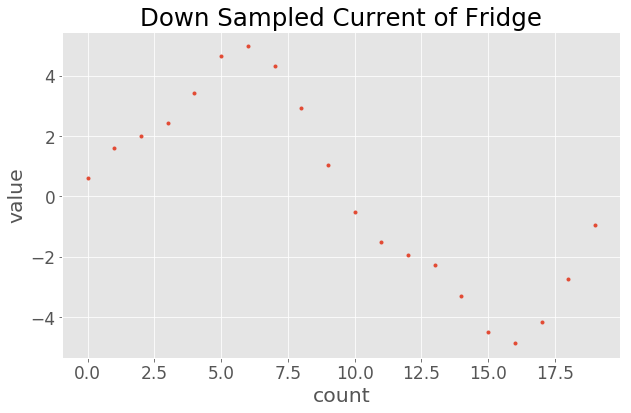

In [30]:
i = 100
plt.plot(BinF_I[i,:],'.')
plt.title('Down Sampled Current of ' + Unq_type[type_label[i]])
plt.xlabel('count')
plt.ylabel('value')
plt.show()

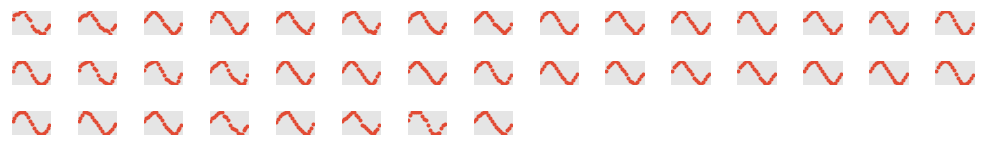

In [31]:
# visualization of all Bin current features from certain type in BinF
type_id = 4
n = sum(type_label==type_id)
fig = plt.figure(figsize=(14,np.ceil(n/15)))
count = 1
for i in np.where(type_label==type_id)[0]:
    plt.subplot(np.ceil(n/10),15,count)
    plt.plot(BinF_I[i,],'.')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     plt.title('Id: '+str(k),fontsize=10)
    count += 1
fig.tight_layout()
plt.show()  

## 5. VI binary image
**BinaryF**: Raw 0/1 binary VI images

In [32]:
def center(X,w):
    minX = np.amin(X)
    maxX = np.amax(X)
    dist = max(abs(minX),maxX)
    X[X<-dist] = -dist
    X[X>dist] = dist
    d = (maxX-minX)/w
    return (X,d)
    
def get_img_from_VI(V, I, width,hard_threshold=False,para=.5):
    '''Get images from VI, hard_threshold, set para as threshold to cut off,5-10
    soft_threshold, set para to .1-.5 to shrink the intensity'''
    
    d = V.shape[0]
    # doing interploation if number of points is less than width*2
    if d<2* width:
        newI = np.hstack([V, V[0]])
        newV = np.hstack([I, I[0]])
        oldt = np.linspace(0,d,d+1)
        newt = np.linspace(0,d,2*width)
        I = np.interp(newt,oldt,newI)
        V = np.interp(newt,oldt,newV)
    # center the current and voltage, get the size resolution of mesh given width    
    (I,d_c)  = center(I,width)
    (V,d_v)  = center(V,width)
    
    #  find the index where the VI goes through in current-voltage axis
    ind_c = np.floor((I-np.amin(I))/d_c).astype(int)
    ind_v = np.floor((V-np.amin(V))/d_v).astype(int)
    ind_c[ind_c==width] = width-1
    ind_v[ind_v==width] = width-1
    
    Img = np.zeros((width,width))
    
    for i in range(len(I)):
        Img[ind_c[i],width-ind_v[i]-1] += 1
    
    if hard_threshold:
        Img[Img<para] = 0
        Img[Img!=0] = 1
        return Img
    else:
        return (Img/np.max(Img))**para
    

In [33]:
n = len(Data)
width = 16

Imgs = np.zeros((n,width,width), dtype=np.float64)
for i in range(n):
    Imgs[i,:,:] = get_img_from_VI(rep_V[i,], rep_I[i,], width,True,1)
BinaryF=np.reshape(Imgs,(n,width*width))

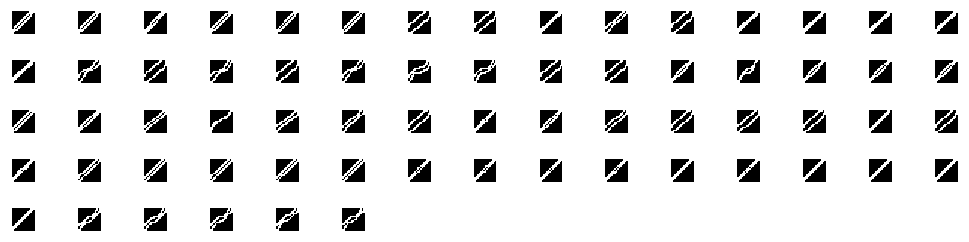

In [34]:
# visualization of all imgaes from certain type in Imgs
type_id = 1
n = sum(type_label==type_id)
fig = plt.figure(figsize=(14,np.ceil(n/15)))
count = 1
for i in np.where(type_label==type_id)[0]:
    plt.subplot(np.ceil(n/10),15,count)
    plt.imshow(Imgs[i,:,:],cmap = cm.Greys_r,interpolation='None')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     plt.title('Id: '+str(k),fontsize=10)
    count += 1
fig.tight_layout()
plt.show()  

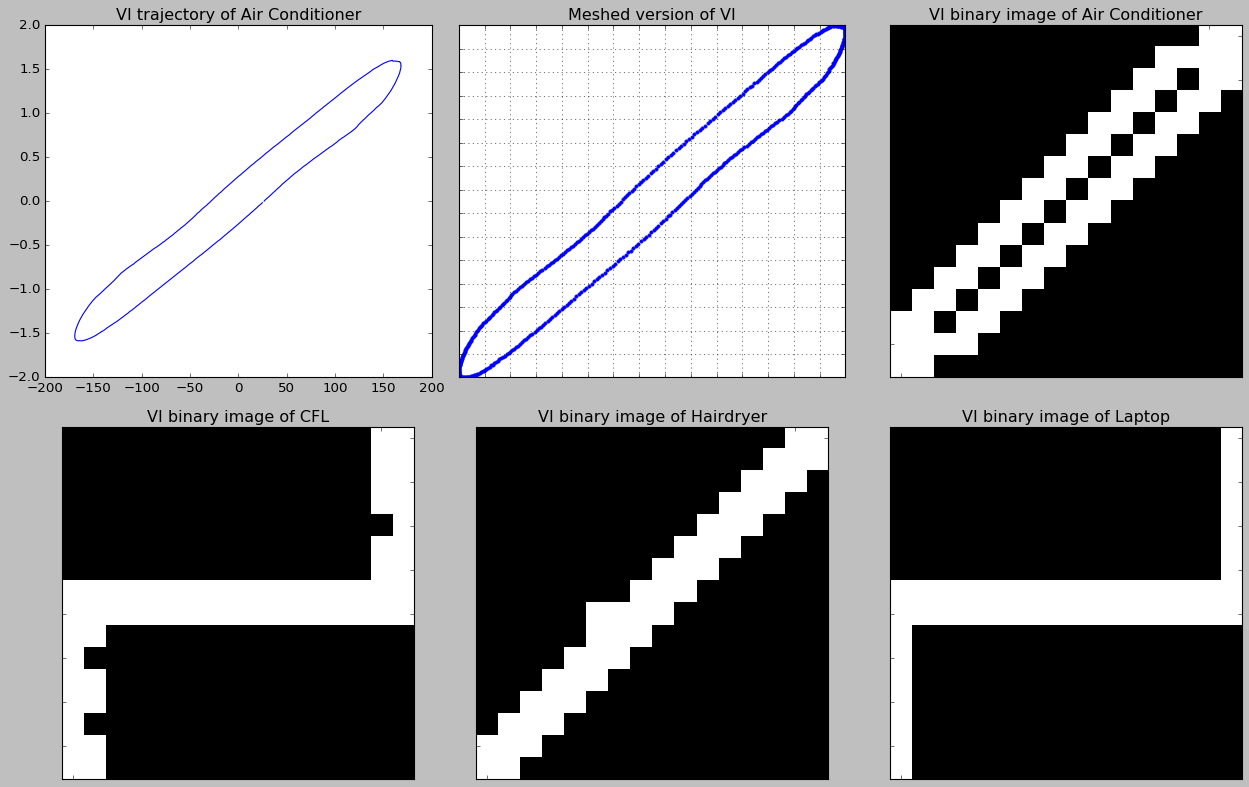

In [35]:
plt.style.use('classic')
# AC-1,CFL-2,hairdryer-5,laptop-8
ix=np.where(type_label==1)[0][30]
fig=plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,3,1)
plt.plot(rep_V[ix,:],rep_I[ix,:])
plt.title('VI trajectory of Air Conditioner')
# plt.xlabel('Voltage')
# plt.ylabel('Current')

ax = fig.add_subplot(2,3,2)
plt.plot(rep_V[ix,:],rep_I[ix,:],'.')
xticks = np.linspace(min(rep_V[ix,:]),max(rep_V[ix,:]),num=16)
yticks = np.linspace(min(rep_I[ix,:]),max(rep_I[ix,:]),num=16)
plt.axis([min(rep_V[ix,:]),max(rep_V[ix,:]),min(rep_I[ix,:]),max(rep_I[ix,:])])
ax.set_xticks(xticks)
ax.set_yticks(yticks)
plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')
# plt.tick_params(axis='y',which='both',labelbottom='off')
plt.title('Meshed version of VI')
ax.grid(which='both')

ax3 = fig.add_subplot(2,3,3)
plt.imshow(Imgs[ix,:,:],cmap = cm.Greys_r,interpolation='None')
plt.title('VI binary image of Air Conditioner')
plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')

ax4 = fig.add_subplot(2,3,4)
ix=np.where(type_label==2)[0][13]
plt.imshow(Imgs[ix,:,:],cmap = cm.Greys_r,interpolation='None')
plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')
plt.title('VI binary image of CFL')


ax5 = fig.add_subplot(2,3,5)
ix=np.where(type_label==5)[0][19]
plt.imshow(Imgs[ix,:,:],cmap = cm.Greys_r,interpolation='None')
plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')
plt.title('VI binary image of Hairdryer')

ax6 = fig.add_subplot(2,3,6)
ix=np.where(type_label==8)[0][13]
plt.imshow(Imgs[ix,:,:],cmap = cm.Greys_r,interpolation='None')
plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')
plt.title('VI binary image of Laptop')


plt.tight_layout()
plt.show()
fig.savefig('VI.eps', format='eps')
plt.style.use('ggplot')

## 6. PCA on abve three
**PCA_BinF, PCA_BinaryF, PCA_RawCF**: Use projected components which keep more than 99% variations as the features

In [36]:
from sklearn.decomposition import PCA

# write a function to extract up to certain percent of projected components
def get_PCs(X,p):
    # X: nd array of size sample_nums*features, 
    # p: percentage of variation to be taken
    pca = PCA(whiten=True)
    pca.fit(X)
    ix=np.where(np.cumsum(pca.explained_variance_ratio_)>p)[0][0]
    pca = PCA(n_components=ix,whiten=True)
    return pca.fit_transform(X)
    

In [37]:
p = .99
PCA_BinF = get_PCs(BinF,p)
PCA_BinaryF = get_PCs(BinaryF,p)
PCA_RawCF = get_PCs(RawCF,p)

In [38]:
np.isnan(np.sum(PCA_BinF))

False

In [39]:
np.isnan(np.sum(PCA_BinaryF))

False

In [40]:
np.isnan(np.sum(PCA_RawCF))

False

# TSNE vs PCA

To visualize the features, we use TSNE and PCA to project them into 2 dimensional space.

In [41]:
def lowDimVisualize(F,filename):

    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    model = TSNE(n_components=2, random_state=0)
    pca = PCA(n_components=2,whiten=True)
    newHar = model.fit_transform(F)

    TSNEF = newHar
    PCAF = pca.fit_transform(F)


    colors = cm.rainbow(np.linspace(0, 1, 11))
    Legends=('AC','CFL','Fan','Fridge','Hairdryer','Heater','Bulb','Laptop','Microwave','Vaccum','Washer')
    # markers='ov^<>sph+Dx'
    fig = plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    for i, c in zip(range(11), colors):
        ix = np.where(type_label==i+1)[0]
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color=c,label=Legends[i])
    plt.title('2D Visulization of TSNE')
    plt.subplot(1,2,2)
    for i, c in zip(range(11), colors):
        ix = np.where(type_label==i+1)[0]
        plt.scatter(PCAF[ix,0], PCAF[ix,1], color=c,label=Legends[i])
    plt.title('2D Visulization of PCA')

    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    # plt.tight_layout()
    fig.savefig(filename, format='eps')

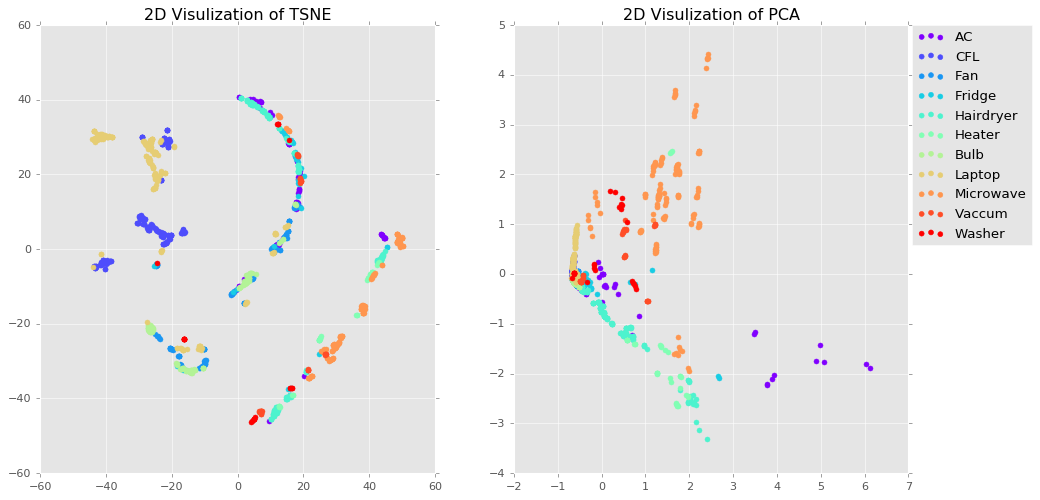

In [42]:
# look at harmonics
lowDimVisualize(HarmonicsF,'harmonics_TSNE_PCA.eps')

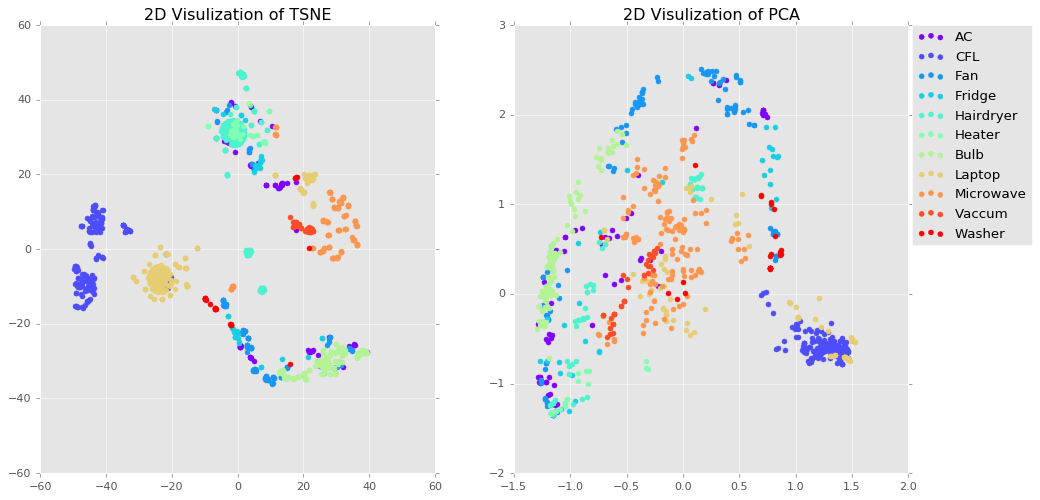

In [43]:
# look at binary images
lowDimVisualize(BinaryF,'Binary_TSNE_PCA.eps')

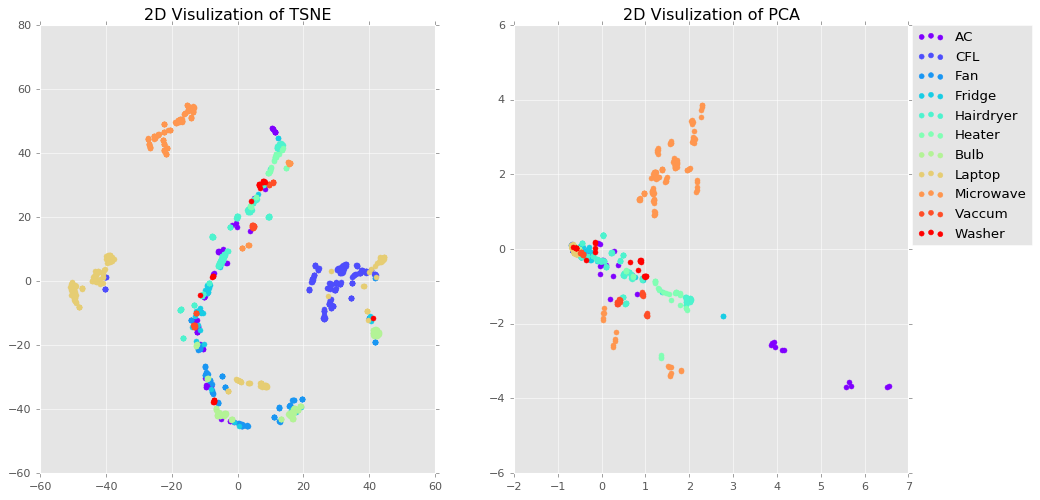

In [44]:
# look at raw current
lowDimVisualize(RawCF,'raw_current_TSNE_PCA.eps')

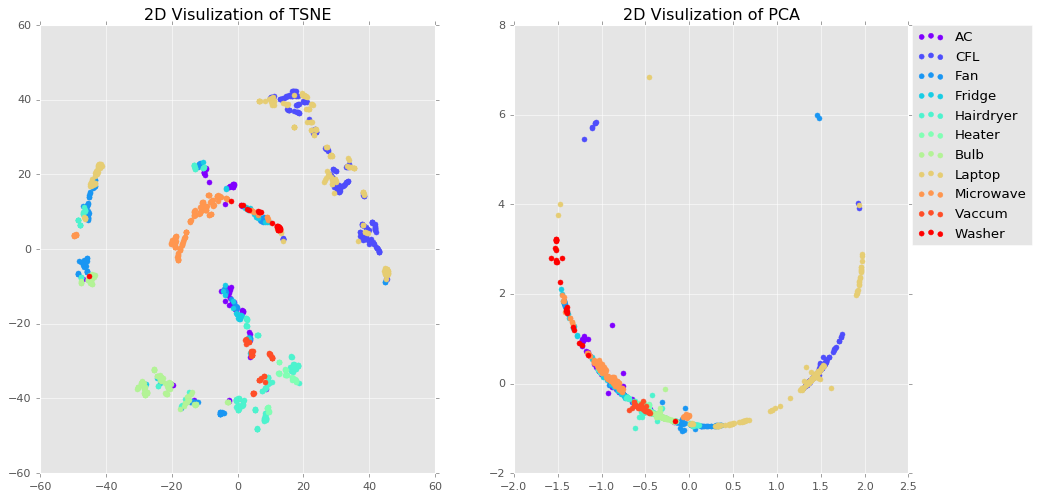

In [45]:
# look at one period of representative current and voltage
lowDimVisualize(np.hstack([rep_I,rep_V]),'raw_IV_1P_TSNE_PCA.eps')

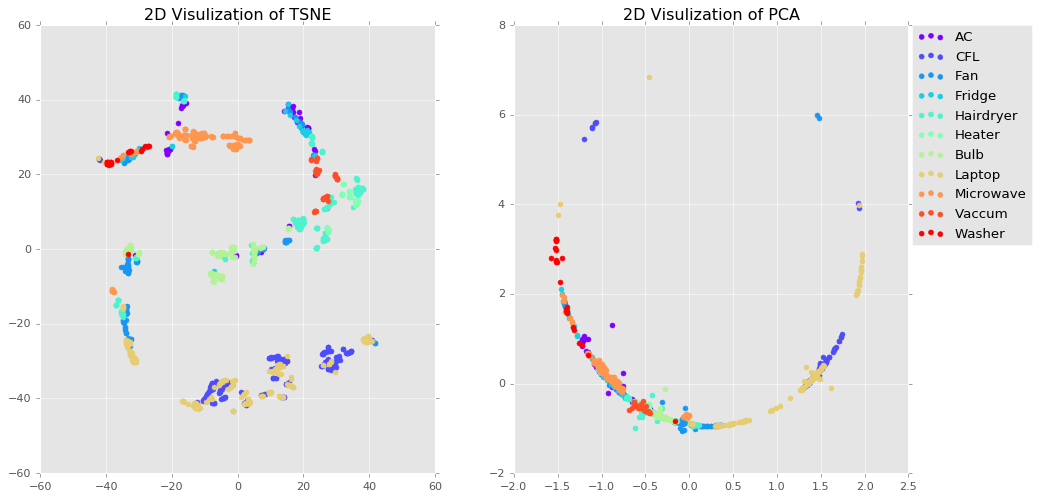

In [46]:
# look at down sampled feature
lowDimVisualize(BinF,'down_sampled_TSNE_PCA.eps')

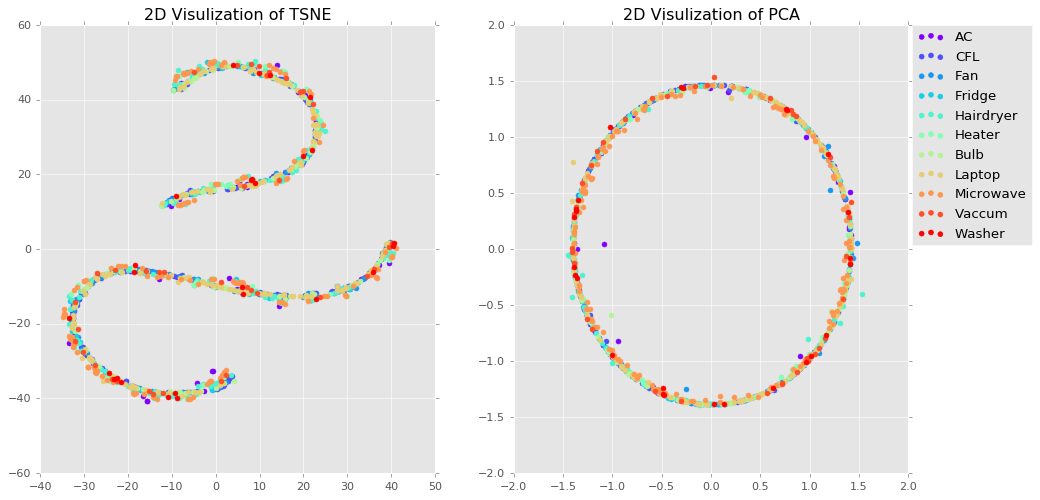

In [47]:
# look at Raw
D=np.array([np.hstack([Data[i+1]['current'],Data[i+1]['voltage']]) for i in range(1074)])
lowDimVisualize(D,'raw_TSNE_PCA.eps')

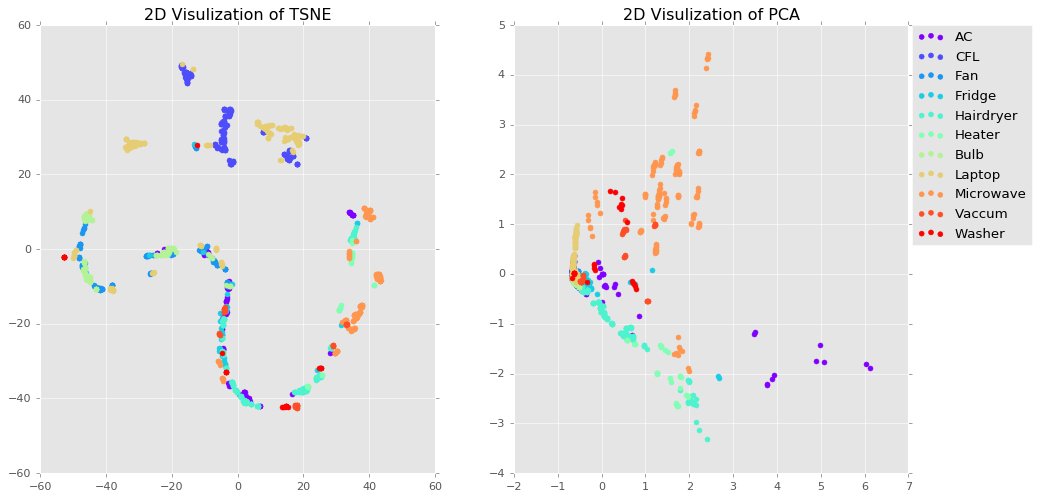

In [48]:
# look at combined 
allF = np.concatenate((PQ, HarmonicsF,BinF, BinaryF),axis=1)
lowDimVisualize(allF,'combined_TSNE_PCA.eps')

# Evaluation

A reasonable way to evalute the features is to train and test on different appliances, to makes sure the test instances won't show up in the training set, we propose an evaluation strategy. There are 55 households, we train on some households and test on the rest. Here we use leave-one-out cross-validation, where we train on 54 households on test on the rest one household. The process is repeated 55 times and the mean accuracy is reported.

In [49]:
# We orgainze the variables to be used
allF = np.concatenate((PQ, HarmonicsF,BinF, BinaryF),axis=1)
F = [RawCF, PQ, HarmonicsF,BinF, BinaryF, PCA_RawCF, PCA_BinF, PCA_BinaryF, allF]
namesF = [ 'Raw Current','PQ','Harmonics','Bin Current/Voltage', 'Binary Images', 'PCA on Current', 
          'PCA on Bin Current/Voltage','PCA on Binary Images','Combined']
print('type label:',type_label)
print('location label:', loc_label)
print('number of different types: %d\n'% len(Unq_type),Unq_type)
print('number of different households: %d\b'% len(Unq_loc))

type label: [ 2  2  2 ...,  8  8 11]
location label: [ 1  1  1 ..., 51 51 51]
number of different types: 11
 ['AC', 'CFL', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'Bulb', 'Laptop', 'Microwave', 'Vacuum', 'Washer']
number of different households: 55


In [50]:
for f in F:
    print(f.shape)

(1074, 500)
(1074, 2)
(1074, 22)
(1074, 40)
(1074, 256)
(1074, 3)
(1074, 1)
(1074, 110)
(1074, 320)


In [51]:
start = datetime.now()
n = len(Unq_loc)
num_clf = 9
num_f = len(F)
acc = np.empty([num_f,num_clf])
predictedY = [[np.empty([0],dtype='int')]*num_clf]*num_f
trueY = np.empty([0],dtype='int')
# loop over each household
for i in range(n):   
    print('%d/%d fold...\t time consumed: %ds'%(i+1,n,(datetime.now()-start).seconds))
    # split data into X_train,y_train,X_test,y_test based on households
    ix_test = np.where(loc_label==i+1)[0]
    ix_train = np.where(loc_label!=i+1)[0]
    temp_acc = np.empty([num_f,num_clf])
    # loop over each feature
    for (j,f) in enumerate(F):
        X_test = f[ix_test]
        y_test = type_label[ix_test]
        X_train = f[ix_train]
        y_train = type_label[ix_train]
        
        (temp,y_p,clf_names) = myclassifiers(X_train,y_train,X_test,y_test) 
        temp_acc[j] = np.array(temp)
        predictedY[j] = [np.hstack([predictedY[j][ii],y_p[ii]]) for ii in range(num_clf)]
    trueY = np.hstack([trueY,y_test])
    acc += temp_acc

1/55 fold...	 time consumed: 0s
2/55 fold...	 time consumed: 26s
3/55 fold...	 time consumed: 50s
4/55 fold...	 time consumed: 76s
5/55 fold...	 time consumed: 102s
6/55 fold...	 time consumed: 127s
7/55 fold...	 time consumed: 153s
8/55 fold...	 time consumed: 181s
9/55 fold...	 time consumed: 211s
10/55 fold...	 time consumed: 241s
11/55 fold...	 time consumed: 270s
12/55 fold...	 time consumed: 299s
13/55 fold...	 time consumed: 330s
14/55 fold...	 time consumed: 356s
15/55 fold...	 time consumed: 381s
16/55 fold...	 time consumed: 406s
17/55 fold...	 time consumed: 431s
18/55 fold...	 time consumed: 456s
19/55 fold...	 time consumed: 484s
20/55 fold...	 time consumed: 510s
21/55 fold...	 time consumed: 536s
22/55 fold...	 time consumed: 562s
23/55 fold...	 time consumed: 587s
24/55 fold...	 time consumed: 613s
25/55 fold...	 time consumed: 639s
26/55 fold...	 time consumed: 664s
27/55 fold...	 time consumed: 689s
28/55 fold...	 time consumed: 714s
29/55 fold...	 time consumed: 741s

In [52]:
real_acc_table = np.array([[accuracy_score(trueY, i) for i in j] for j in predictedY])

In [53]:
np.set_printoptions(precision=4)
print(clf_names)
print(real_acc_table)
print(namesF)

['Nearest Neighbors(k=1)', 'Naive Bayes', 'Logistic', 'RBF SVM', 'LDA', 'QDA', 'Decision Tree', 'Random Forest', 'AdaBoost']
[[ 0.7607  0.6173  0.6983  0.4814  0.4693  0.2216  0.7179  0.7831  0.3454]
 [ 0.7169  0.5736  0.5689  0.297   0.2765  0.7235  0.6927  0.7011  0.2309]
 [ 0.7197  0.513   0.5475  0.1443  0.5419  0.6294  0.6555  0.7169  0.3231]
 [ 0.716   0.7142  0.7244  0.1443  0.6136  0.6909  0.7225  0.8277  0.5261]
 [ 0.8091  0.5279  0.7142  0.4283  0.7952  0.3892  0.7272  0.8212  0.4311]
 [ 0.7663  0.635   0.6164  0.5289  0.4143  0.7561  0.7142  0.7412  0.2989]
 [ 0.4711  0.5121  0.4395  0.5177  0.4181  0.5121  0.4777  0.4981  0.3706]
 [ 0.5447  0.5279  0.6276  0.3631  0.7644  0.5019  0.7216  0.7644  0.2793]
 [ 0.7207  0.649   0.7188  0.1443  0.798   0.4953  0.7672  0.8529  0.513 ]]
['Raw Current', 'PQ', 'Harmonics', 'Bin Current/Voltage', 'Binary Images', 'PCA on Current', 'PCA on Bin Current/Voltage', 'PCA on Binary Images', 'Combined']


In [54]:
ix=[0,1,2,6,7]
temp_clf_name=[clf_names[i] for i in ix]
temp_table=real_acc_table[:,ix]
print(temp_clf_name)
print(temp_table)
print(namesF)

['Nearest Neighbors(k=1)', 'Naive Bayes', 'Logistic', 'Decision Tree', 'Random Forest']
[[ 0.7607  0.6173  0.6983  0.7179  0.7831]
 [ 0.7169  0.5736  0.5689  0.6927  0.7011]
 [ 0.7197  0.513   0.5475  0.6555  0.7169]
 [ 0.716   0.7142  0.7244  0.7225  0.8277]
 [ 0.8091  0.5279  0.7142  0.7272  0.8212]
 [ 0.7663  0.635   0.6164  0.7142  0.7412]
 [ 0.4711  0.5121  0.4395  0.4777  0.4981]
 [ 0.5447  0.5279  0.6276  0.7216  0.7644]
 [ 0.7207  0.649   0.7188  0.7672  0.8529]]
['Raw Current', 'PQ', 'Harmonics', 'Bin Current/Voltage', 'Binary Images', 'PCA on Current', 'PCA on Bin Current/Voltage', 'PCA on Binary Images', 'Combined']


In [55]:
print('The highest accuracy is: %.2f' % (1*np.max(real_acc_table)))
(ix1,ix2)=np.where(real_acc_table==np.max(real_acc_table))
print('It is from feature %s using classifier %s'%(namesF[ix1[0]],clf_names[ix2[0]]))

The highest accuracy is: 0.85
It is from feature Combined using classifier Random Forest


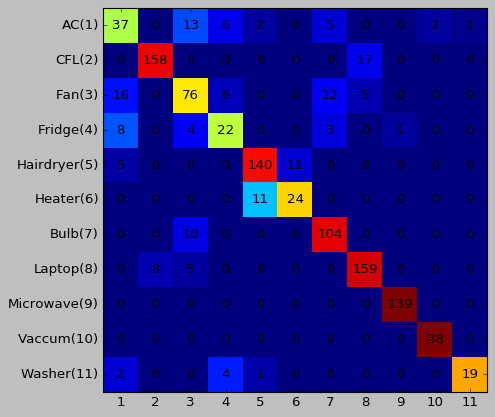

In [56]:
# draw confusion matrix
plt.style.use('classic')
C = sklearn.metrics.confusion_matrix(trueY, predictedY[ix1[0]][ix2[0]])
conf_arr = C
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width = len(conf_arr)
height = len(conf_arr[0])

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)



# alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
alphabet=['AC(1)','CFL(2)','Fan(3)','Fridge(4)','Hairdryer(5)','Heater(6)','Bulb(7)','Laptop(8)','Microwave(9)','Vaccum(10)','Washer(11)']
xlabels=['1','2','3','4','5','6','7','8','9','10','11']
plt.xticks(range(width), xlabels[:width])
plt.yticks(range(height), alphabet[:height])
# plt.savefig('confusion_matrix.png', format='png',dpi=800)
plt.savefig('confusion_matrix.eps', format='eps')
plt.style.use('ggplot')

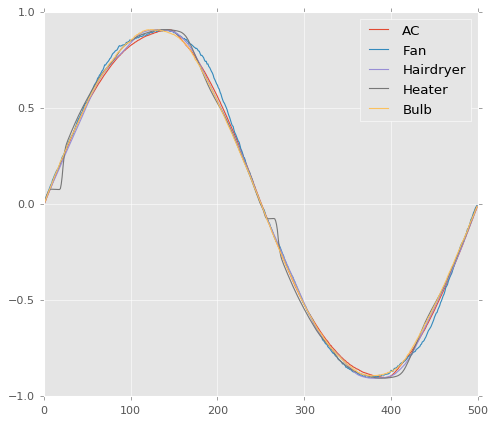

In [57]:
# plot four instances
ids = [1,3,5,6,7]
normalize = lambda x:x/(max(x)*1.1)
plt.figure(figsize=(7,6))
for i in ids:
    plt.plot(normalize(RawCF[np.where(type_label==i)[0][0],]),label=Unq_type[i-1])
    plt.legend()

## Downsample test

In [58]:
def downsample(X,newN):
    newN = int(newN)
    D = len(X)
    seg = D//newN
    newX = np.zeros([newN])
    for i in range(newN):
        newX[i] = X[seg*i]
    return newX

In [59]:
m = len(Data)
n = len(Unq_loc)
num_clf = 9
width = 16
fs = 3e4
f0 = 60
# from 30k Hz to 200 Hz
new_fs = [3e4,2e4]+[i*1e3 for i in range(10,0,-1)] + [i*1e2 for i in range(9,1,-1)]
# new_fs = [i*1e3 for i in range(3,0,-1)] + [i*1e2 for i in range(9,1,-1)]
n_fs = len(new_fs)
img_acc = np.empty([n_fs,num_clf])
predictedY = [[np.empty([0],dtype='int')]*num_clf]*n_fs

# loop over sampling frequency
start = datetime.now()

for ii in range(n_fs):
    NN = new_fs[ii]//f0
    new_Imgs = np.zeros((m,width,width), dtype=np.float64)
    # extract VI image feature for corresponding sampling frequency
    for j in range(m):
        new_V = downsample(rep_V[j,],NN)
        new_I = downsample(rep_I[j,],NN)
        new_Imgs[j,:,:] = get_img_from_VI(new_V, new_I, width, True,1)
#         new_Imgs[j,:,:] = get_img_from_VI(rep_V[j,], rep_I[j,], width,True,1)
    newBinaryF=np.reshape(new_Imgs,(m,width*width))
    print('%d/%d\t sampling frequency:%6.0f Hz'%(ii+1,n_fs,new_fs[ii]),end='')
    # train/test for each household
    trueY = np.empty([0],dtype='int')
    for i in range(n):   
        # split data into X_train,y_train,X_test,y_test based on households
        ix_test = np.where(loc_label==i+1)[0]
        ix_train = np.where(loc_label!=i+1)[0]
        X_test = newBinaryF[ix_test]
        y_test = type_label[ix_test]
        X_train = newBinaryF[ix_train]
        y_train = type_label[ix_train]
        (_,y_p,_) = myclassifiers(X_train,y_train,X_test,y_test) 
        predictedY[ii] = [np.hstack([predictedY[ii][jj],y_p[jj]]) for jj in range(num_clf)]
        trueY = np.hstack([trueY,y_test])
#         print('%d/%d -- %d/%d fold...\t time consumed: %ds'%(ii,n_fs,i+1,n,(datetime.now()-start).seconds))
    img_acc[ii,]= np.array([accuracy_score(trueY, jj) for jj in predictedY[ii]])
    print("\t time consumed: %4ds\t accuracy: %.2f" % ((datetime.now()-start).seconds, max(img_acc[ii,])))

1/20	 sampling frequency: 30000 Hz	 time consumed:   75s	 accuracy: 0.81
2/20	 sampling frequency: 20000 Hz	 time consumed:  149s	 accuracy: 0.84
3/20	 sampling frequency: 10000 Hz	 time consumed:  226s	 accuracy: 0.82
4/20	 sampling frequency:  9000 Hz	 time consumed:  302s	 accuracy: 0.84
5/20	 sampling frequency:  8000 Hz	 time consumed:  381s	 accuracy: 0.82
6/20	 sampling frequency:  7000 Hz	 time consumed:  456s	 accuracy: 0.84
7/20	 sampling frequency:  6000 Hz	 time consumed:  533s	 accuracy: 0.81
8/20	 sampling frequency:  5000 Hz	 time consumed:  623s	 accuracy: 0.80
9/20	 sampling frequency:  4000 Hz	 time consumed:  702s	 accuracy: 0.82
10/20	 sampling frequency:  3000 Hz	 time consumed:  781s	 accuracy: 0.79
11/20	 sampling frequency:  2000 Hz	 time consumed:  852s	 accuracy: 0.80
12/20	 sampling frequency:  1000 Hz	 time consumed:  926s	 accuracy: 0.77
13/20	 sampling frequency:   900 Hz	 time consumed: 1000s	 accuracy: 0.73
14/20	 sampling frequency:   800 Hz	 time consu

In [60]:
np.set_printoptions(precision=2)
print(img_acc*100)

[[ 80.91  52.79  71.42  42.83  79.52  38.92  73.37  81.47  39.85]
 [ 80.45  59.59  75.33  42.83  82.4   49.91  71.23  83.52  27.56]
 [ 80.45  46.37  72.44  38.55  79.33  41.53  73.84  81.94  33.99]
 [ 81.38  64.53  75.7   35.47  82.31  44.51  72.91  83.71  28.58]
 [ 78.68  59.68  73.28  37.24  81.94  51.68  75.33  82.4   36.69]
 [ 81.01  60.06  72.16  32.96  83.43  49.91  74.49  83.52  31.1 ]
 [ 79.24  51.3   68.72  33.43  78.58  37.06  73.28  81.01  29.8 ]
 [ 78.12  44.04  62.57  31.19  76.44  39.76  73.46  80.26  32.68]
 [ 79.7   55.59  70.67  27.56  81.84  48.04  67.6   82.31  29.61]
 [ 74.39  45.16  65.74  26.54  76.82  33.24  62.76  78.68  30.17]
 [ 78.96  48.88  70.58  16.39  80.17  37.52  67.5   76.82  31.66]
 [ 76.72  49.53  62.76  25.7   75.14  38.64  60.8   74.86  32.12]
 [ 72.91  47.58  60.24  21.32  70.2   21.97  60.52  71.04  38.73]
 [ 75.23  49.16  62.38  21.32  71.14  27.75  60.99  71.97  24.39]
 [ 75.79  48.51  64.62  16.85  74.49  21.23  58.85  71.97  29.24]
 [ 71.69  

In [61]:
ix=[0,1,2,6,7]
legend_names=("kNN(1)", "GNB","LGC","DTree","RForest")
acc_plot=img_acc[:,ix]
print(legend_names)
print(acc_plot)
print(new_fs)
acc_plot

('kNN(1)', 'GNB', 'LGC', 'DTree', 'RForest')
[[ 0.81  0.53  0.71  0.73  0.81]
 [ 0.8   0.6   0.75  0.71  0.84]
 [ 0.8   0.46  0.72  0.74  0.82]
 [ 0.81  0.65  0.76  0.73  0.84]
 [ 0.79  0.6   0.73  0.75  0.82]
 [ 0.81  0.6   0.72  0.74  0.84]
 [ 0.79  0.51  0.69  0.73  0.81]
 [ 0.78  0.44  0.63  0.73  0.8 ]
 [ 0.8   0.56  0.71  0.68  0.82]
 [ 0.74  0.45  0.66  0.63  0.79]
 [ 0.79  0.49  0.71  0.68  0.77]
 [ 0.77  0.5   0.63  0.61  0.75]
 [ 0.73  0.48  0.6   0.61  0.71]
 [ 0.75  0.49  0.62  0.61  0.72]
 [ 0.76  0.49  0.65  0.59  0.72]
 [ 0.72  0.55  0.62  0.64  0.76]
 [ 0.79  0.59  0.72  0.6   0.77]
 [ 0.75  0.67  0.7   0.69  0.77]
 [ 0.79  0.59  0.68  0.67  0.77]
 [ 0.68  0.59  0.7   0.65  0.72]]
[30000.0, 20000.0, 10000.0, 9000.0, 8000.0, 7000.0, 6000.0, 5000.0, 4000.0, 3000.0, 2000.0, 1000.0, 900.0, 800.0, 700.0, 600.0, 500.0, 400.0, 300.0, 200.0]


array([[ 0.81,  0.53,  0.71,  0.73,  0.81],
       [ 0.8 ,  0.6 ,  0.75,  0.71,  0.84],
       [ 0.8 ,  0.46,  0.72,  0.74,  0.82],
       [ 0.81,  0.65,  0.76,  0.73,  0.84],
       [ 0.79,  0.6 ,  0.73,  0.75,  0.82],
       [ 0.81,  0.6 ,  0.72,  0.74,  0.84],
       [ 0.79,  0.51,  0.69,  0.73,  0.81],
       [ 0.78,  0.44,  0.63,  0.73,  0.8 ],
       [ 0.8 ,  0.56,  0.71,  0.68,  0.82],
       [ 0.74,  0.45,  0.66,  0.63,  0.79],
       [ 0.79,  0.49,  0.71,  0.68,  0.77],
       [ 0.77,  0.5 ,  0.63,  0.61,  0.75],
       [ 0.73,  0.48,  0.6 ,  0.61,  0.71],
       [ 0.75,  0.49,  0.62,  0.61,  0.72],
       [ 0.76,  0.49,  0.65,  0.59,  0.72],
       [ 0.72,  0.55,  0.62,  0.64,  0.76],
       [ 0.79,  0.59,  0.72,  0.6 ,  0.77],
       [ 0.75,  0.67,  0.7 ,  0.69,  0.77],
       [ 0.79,  0.59,  0.68,  0.67,  0.77],
       [ 0.68,  0.59,  0.7 ,  0.65,  0.72]])

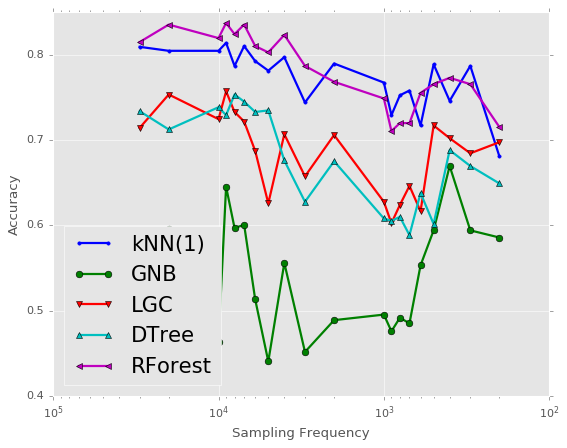

In [62]:
fig = plt.figure()
markers='.ov^<>'
colors='bgrcmk'
legend_names=("kNN(1)", "GNB","LGC","DTree","RForest")

for i in range(5):
    plt.semilogx(new_fs, acc_plot[:,i],colors[i]+markers[i]+'-',label=legend_names[i],linewidth=2.0)
# plt.title('semilogx')
plt.grid(True)
plt.gca().invert_xaxis()
# plt.legend(bbox_to_anchor=(1.05, 1),loc=1, borderaxespad=0.)
plt.legend(loc='lower left',prop={'size':19})
# fig.legend((tuple(l)),(legend_names),'upper right')
# fig.legend((l[0],l[1],l[2],l[3],l[4]),legend_names,'upper right')
plt.xlabel('Sampling Frequency')
plt.ylabel('Accuracy')
# plt.ylim([0,1])
# plt.show()
# plt.savefig('acc_fs.png', format='png',dpi=800)
# plt.savefig('acc_fs.eps', format='eps')